<a href="https://colab.research.google.com/github/Rob685/coolstarsucsd/blob/master/smss_red_refset_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a new SkyMapper Reference and Training Sets

I'm re-tracing some steps and reading new skymapper data downloaded on 05/20/2020 because I can't find the original data that we used to build the old one. Also, I applied the completion cuts right as I downloaded them in Coldbrew using `all_skymapper_reading.py`. The cuts are the following:

1. $i - z > 0.75$
2. $i\_psf < 20.0$, $z\_psf < 19.0$
3. `flags == 0`

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import ascii
from astropy.table import Table
from astropy.io.misc.hdf5 import read_table_hdf5
from collections import Counter
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

path_sm = 'gdrive/My Drive/Colab Notebooks/sm_workspace/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=2.5) # change back to 1.5
plt.rc('axes', labelsize=15) # change back to 10
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=15) # change back to 7

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
#! sudo apt-get install dvipng texlive-fonts-recommended #2
! sudo apt-get install cm-super
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended 
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [ ]:
# extracted data:
smss = pd.read_csv(path_sm+'/all_skymapper_data.csv.gz',compression='gzip')
smss.shape

(617101, 104)

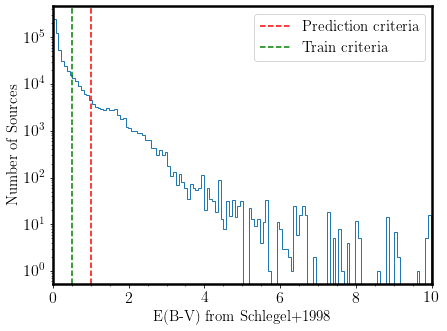

In [ ]:
# plotting the extinction values:
fig = plt.figure(1,figsize=(2*3.4, 2*3.4*3/4.))
plt.hist(smss['ebmv_sfd'],histtype='step',bins=500,log=True)
plt.xlabel('E(B-V) from Schlegel+1998')
plt.ylabel('Number of Sources')
plt.axvline(x=1.0,ls='--',color='r',label='Prediction criteria')
plt.axvline(x=0.5,ls='--',color='g',label='Train criteria')
plt.xlim(0,10)
plt.legend()
plt.minorticks_on()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_extinction_values_cuts.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
# selecting objects outside the galactic plane:
smss = smss[(abs(smss['glat'] > 20.0)) 
            & (smss['ebmv_sfd'] < 1.0)
            ]
smss.shape

(117471, 104)

In [ ]:
# saving coordinates for cross-matching:
#smss[['object_id','raj2000','dej2000']].to_csv(path_sm+'smss_red_data_coords.csv',index=False)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


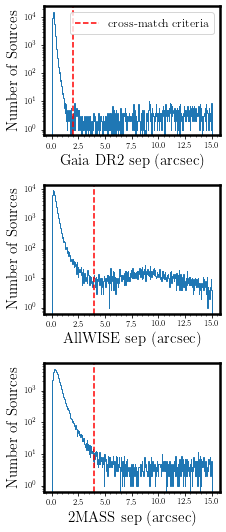

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 3*3.4*3/4.))
ax1=plt.subplot(311)
ax1.hist(smss['gaia_dr2_dist1'],histtype='step',bins=500,log=True)
ax1.set_xlabel('Gaia DR2 sep (arcsec)')
ax1.set_ylabel('Number of Sources')
ax1.axvline(x=2.0,ls='--',color='r',label='cross-match criteria')
ax1.legend(prop={'size':12})
ax1.minorticks_on()

ax2=plt.subplot(312)
ax2.hist(smss['allwise_dist'],histtype='step',bins=500,log=True)
ax2.set_xlabel('AllWISE sep (arcsec)')
ax2.set_ylabel('Number of Sources')
ax2.axvline(x=4.0,ls='--',color='r')
ax2.minorticks_on()

ax3=plt.subplot(313)
ax3.hist(smss['twomass_dist1'],histtype='step',bins=500,log=True)
ax3.set_xlabel('2MASS sep (arcsec)')
ax3.set_ylabel('Number of Sources')
ax3.axvline(x=4.0,ls='--',color='r')
ax3.minorticks_on()

plt.tight_layout()

#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_xmatch_values_cuts.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# Merging to obtain all columns:

In [ ]:
def merger(df1,df2,r_col,l_col,method):
  df3 = df1.merge(df2,left_on=l_col,right_on=r_col,how=method,suffixes=('','_y'))
  df3 = df3.drop(df3.filter(regex='_y').columns, axis=1)
  df3 = df3.drop_duplicates(subset=l_col)
  return df3

In [ ]:
smss_gdr2_topcat = pd.read_csv(path_sm+'smss_red_gaiadr2_topcat.csv')
smss_gdr2_topcat.shape

In [ ]:
smss_aw = pd.read_csv(path_sm+'smss_red_allwise.csv',low_memory=False)
smss_aw = smss_aw.rename(columns={'ph_qual':'ph_qual_aw'})
smss_tm = pd.read_csv(path_sm+'smss_red_twomass.csv',low_memory=False)
smss_tm = smss_tm.rename(columns={'ph_qual':'ph_qual_tm'})

# need to take out dupes because I matched to Gaia using CDS X-Match...
smss_gdr2 = pd.read_csv(path_sm+'smss_red_gaiadr2.csv',low_memory=False)
smss_gdr2 = smss_gdr2.sort_values('angDist', ascending=True).drop_duplicates('object_id') # sorts data to select nearest match from duplicates

smss_gdr2_distances = pd.read_csv(path_sm+'smss_red_data_distances.csv',low_memory=False)

print(smss_aw.shape)
print(smss_tm.shape)
print(smss_gdr2.shape)

In [ ]:
# merge on to obtain all columns:
merger_test = merger(smss_gdr2_distances,smss_gdr2_topcat,l_col='object_id',r_col='object_id',method='inner')
merger_test_nodupes = merger_test.sort_values('angDist', ascending=True).drop_duplicates('object_id')
print(merger_test.shape)
print(merger_test_nodupes.shape)

(574490, 113)
(574490, 113)


In [ ]:
#smss_gdr2[['ra','dec']].to_csv(path_sm+'smss_red_gaiadr2_coords.tsv',sep='\t',header=False,index=False)
#smss_gdr2[['object_id','ra','dec']].to_csv(path_sm+'smss_red_gaiadr2_coords.csv',index=False)

In [ ]:
smss_merged1 = merger(smss,merger_test,r_col='object_id',l_col='object_id',method='left')
print(smss_merged1.shape)

smss_merged2 = merger(smss_merged1,smss_aw,r_col='t1_object_id',l_col='object_id',method='left')
print(smss_merged2.shape)

smss_merged3 = merger(smss_merged2,smss_tm,r_col='t1_object_id',l_col='object_id',method='left')
print(smss_merged3.shape)

(117471, 213)
(117471, 309)
(117471, 363)


In [ ]:
# allwise cuts:

snr = 10.0

data_clean1 = smss_merged3[smss_merged3['ph_qual_aw'].str.startswith(('AA'),na=False)]
print(data_clean1.shape)
data_clean2 = data_clean1[data_clean1['ext_flg'] == 0.0]
print(data_clean2.shape)
data_clean3 = data_clean2[data_clean2['cc_flags'].str.startswith(('00'),na=False) 
                          & (data_clean2['w1snr'] > snr) 
                          & (data_clean2['w2snr'] > snr)
                          ]
print(data_clean3.shape)

(101091, 363)
(98799, 363)
(92152, 363)


In [ ]:
# twomass cuts:
data_clean4 = data_clean3[(data_clean3['ph_qual_tm'] == 'AAA') 
                          & (data_clean3['cc_flg'] == '000') 
                          & (data_clean3['gal_contam'] == 0)
                          ]
print(data_clean4.shape)
data_clean5 = data_clean4[(data_clean4['j_snr'] > snr) 
                          & (data_clean4['h_snr'] > snr) 
                          & (data_clean4['k_snr'] > snr)
                          ]
print(data_clean5.shape)

(36360, 363)
(36262, 363)


In [ ]:
# saving as compressed file becaues it's huge:
data_clean5.to_csv(path_sm+'smss_merged3.csv.gz',compression='gzip',index=False)

# Beginning to cut for the Training Set

Start here for extinction cuts, gaia parallax cuts, and quality cuts

In [ ]:
smss_merged3 = pd.read_csv(path_sm+'smss_merged3.csv.gz',compression='gzip',low_memory=False)

In [ ]:
smss_merged3_dered = smss_merged3[smss_merged3['ebmv_sfd'] < 0.5]
smss_merged3_dered.shape

(34187, 363)

In [ ]:
len(smss_merged3_dered)/len(smss_merged3)

0.9427775632893939

In [ ]:
# selecting positive parallaxes:
pos_par = smss_merged3_dered[smss_merged3_dered['parallax'] > 0.0]
pos_par.shape

(30624, 363)

In [ ]:
len(pos_par)/len(smss_merged3_dered)

0.8957790973176939

In [ ]:
sigma_cut = pos_par[pos_par['parallax'] > 3*pos_par['parallax_error']]
sigma_cut.shape

(30055, 363)

In [ ]:
len(sigma_cut)/len(pos_par)

0.9814198014629049

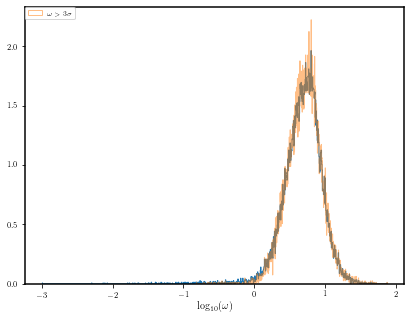

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))
ax1=plt.hist(np.log10(pos_par['parallax']),bins=1000,histtype='step',density=True)
ax2=plt.hist(np.log10(sigma_cut['parallax']),bins=1000,alpha=0.5,histtype='step',density=True,label='$\omega > 3\sigma$')
#plt.hist(des_c4_g['log_par'],bins=1000,histtype='step',density=True)
plt.xlabel('$\log_{10}(\omega)$')
leg=plt.legend(loc='upper left',markerscale=5, borderaxespad=0.)
for l in leg.get_lines():
    l.set_alpha(1)
#ax2.set_alpha(0.5)
plt.show()

## Investigating M_i space
Defining absolute magnitude:

$$M = m - 5\log(1000/\omega) + 5$$

where $\omega$ is the parallax in milli-arcseconds.

In [ ]:
def M(d, m):
    return m - 5*np.log10(d) + 5

In [ ]:
sigma_cut['M_i'] = M(sigma_cut['rest'],sigma_cut['i_psf'])
sigma_cut['i_z'] = sigma_cut['i_psf'] - sigma_cut['z_psf']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


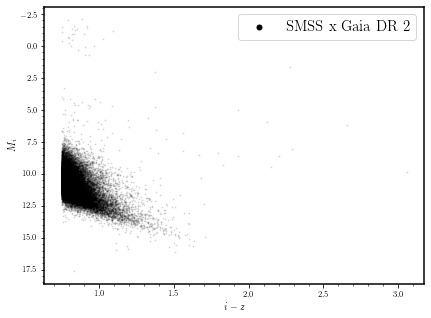

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))
#ax2=plt.scatter(data_clean3['i_z'],data_clean3['M_i'],s=1,c='k',label='DES Data')
#ax3=plt.scatter(kiman_des_clean['i_z'],kiman_des_clean['M_i'],s=5,c='r',label='Kiman et al (2019)')
ax1=plt.scatter(sigma_cut['i_psf'] - sigma_cut['z_psf'],sigma_cut['M_i'],s=1,c='k',label='SMSS x Gaia DR 2')
#ax4=plt.scatter(gagne_lty_clean['i_z'],gagne_lty_clean['M_i'],s=10,c='g',label='Gagne LT')
#plt.axhline(y=10)
plt.xlabel('$i - z$')
plt.ylabel('$M_i$')
leg=plt.legend(loc='best',markerscale=5, fontsize=15)
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
#ax2.set_alpha(0.1)
#ax3.set_alpha(1.0)
#ax4.set_alpha(1.0)
plt.minorticks_on()

plt.gca().invert_yaxis()
plt.show()

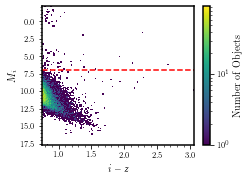

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 1*3.4*3/4.))
plt.hist2d(sigma_cut['i_z'],sigma_cut['M_i'],bins=300,norm=LogNorm(),rasterized=True)
plt.axhline(y=7,ls='--',color='r')
plt.xlabel('$i - z$')
plt.ylabel('$M_i$')
plt.colorbar().set_label('Number of Objects')
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_train_Mi_iz_hist2d.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# Merging with Kiman and Gagne

In [ ]:
path_kiman = 'gdrive/My Drive/Colab Notebooks/kiman_etal_mdwarfs/'
kiman_sm = pd.read_csv(path_kiman+'kiman_sm_goodastro_chris.csv')
kiman_sm = kiman_sm[kiman_sm['angDist'] <= 5.0]
kiman_sm.shape

(7144, 55)

In [ ]:
kiman_sm['angDist'].max()

4.991778

In [ ]:
kiman_sm_comp = kiman_sm[(kiman_sm['iPSF'] - kiman_sm['zPSF'] >= 0.75)
                         & (kiman_sm['iPSF'] < 20.0) 
                         & (kiman_sm['zPSF'] < 19.0)
                         & (kiman_sm['flags'] == 0)]
kiman_sm_comp = kiman_sm_comp.sort_values('angDist', ascending=True).drop_duplicates('ObjectId') # sorts data to select nearest match from duplicates

kiman_sm_comp.shape # numbers match once we drop duplicates! 695 objects

(693, 55)

In [ ]:
# checkingi if we contain all the matches above within our subsample:
kiman_sm_overlap = merger(smss,kiman_sm_comp,r_col='ObjectId',l_col='object_id',method='inner')
kiman_sm_overlap.shape

(231, 155)

In [ ]:
# checking how many are cut by the quality and parallax cuts:
kiman_sm_overlap_clean = merger(sigma_cut,kiman_sm_comp,r_col='ObjectId',l_col='object_id',method='inner')
kiman_sm_overlap_clean.shape # 505 objects

(152, 413)

In [ ]:
# doing Gagne now:
path_gagne = 'gdrive/My Drive/Colab Notebooks/gagne_dwarfs/'
gagne_m_smss = pd.read_csv(path_gagne+'gagne_m_smss.csv')
print(gagne_m_smss.shape)
gagne_lty_smss = pd.read_csv(path_gagne+'gagne_lty_smss.csv')
print(gagne_lty_smss.shape)

(1451, 44)
(212, 44)


In [ ]:
gagne_m_sm_comp = gagne_m_smss[(gagne_m_smss['iPSF'] - gagne_m_smss['zPSF'] >= 0.75)
                         & (gagne_m_smss['iPSF'] < 20.0) 
                         & (gagne_m_smss['zPSF'] < 19.0)
                         & (gagne_m_smss['flags'] == 0)]
gagne_m_sm_comp = gagne_m_sm_comp.sort_values('angDist', ascending=True).drop_duplicates('ObjectId') # sorts data to select nearest match from duplicates

gagne_m_sm_comp.shape # numbers match once we drop duplicates! 679 objects

(679, 44)

In [ ]:
gagne_lty_sm_comp = gagne_lty_smss[(gagne_lty_smss['iPSF'] - gagne_lty_smss['zPSF'] >= 0.75)
                         & (gagne_lty_smss['iPSF'] < 20.0) 
                         & (gagne_lty_smss['zPSF'] < 19.0)
                         & (gagne_lty_smss['flags'] == 0)]
gagne_lty_sm_comp = gagne_lty_sm_comp.sort_values('angDist', ascending=True).drop_duplicates('ObjectId') # sorts data to select nearest match from duplicates

gagne_lty_sm_comp.shape # numbers match once we drop duplicates! 73 objects

(73, 44)

In [ ]:
# checkingi if we contain all the matches above within our subsample:
gagne_m_overlap = merger(smss,gagne_m_sm_comp,r_col='ObjectId',l_col='object_id',method='inner')
print(gagne_m_overlap.shape)
gagne_lty_overlap = merger(smss,gagne_lty_sm_comp,r_col='ObjectId',l_col='object_id',method='inner')
print(gagne_lty_overlap.shape) # we contain all of them!

(294, 142)
(22, 142)


In [ ]:
# checking how many are cut by the quality and parallax cuts:
gagne_m_overlap_clean = merger(sigma_cut,gagne_m_sm_comp,r_col='ObjectId',l_col='object_id',method='inner')
print(gagne_m_overlap_clean.shape) # 366 objects

gagne_lty_overlap_clean = merger(sigma_cut,gagne_lty_sm_comp,r_col='ObjectId',l_col='object_id',method='inner')
print(gagne_lty_overlap_clean.shape) # 26 objects

(150, 402)
(7, 402)


In [ ]:
# observing where the known dwarfs live in M_i v. i - z parameter space:
kiman_sm_overlap_clean['M_i'] = M(kiman_sm_overlap_clean['rest'],kiman_sm_overlap_clean['i_psf'])
kiman_sm_overlap_clean['i_z'] = kiman_sm_overlap_clean['i_psf'] - kiman_sm_overlap_clean['z_psf']

gagne_m_overlap_clean['M_i'] = M(gagne_m_overlap_clean['rest'],gagne_m_overlap_clean['i_psf'])
gagne_m_overlap_clean['i_z'] = gagne_m_overlap_clean['i_psf'] - gagne_m_overlap_clean['z_psf']

gagne_lty_overlap_clean['M_i'] = M(gagne_lty_overlap_clean['rest'],gagne_lty_overlap_clean['i_psf'])
gagne_lty_overlap_clean['i_z'] = gagne_lty_overlap_clean['i_psf'] - gagne_lty_overlap_clean['z_psf']

## Cutting along $M_i$

Cutting along parallax didn't split the distributions so sharply, so we're defaulting to $M_i$

In [ ]:
def conf_levels(x,y,bin_n):
  # Make a 2d normed histogram
  H,xedges,yedges=np.histogram2d(x,y,bins=bin_n,normed=True)
  norm=H.sum() # Find the norm of the sum
  # Set contour levels
  contour1=0.99
  contour2=0.95
  contour3=0.68

  # Set target levels as percentage of norm
  target1 = norm*contour1
  target2 = norm*contour2
  target3 = norm*contour3

  # Take histogram bin membership as proportional to Likelihood
  # This is true when data comes from a Markovian process
  def objective(limit, target):
      w = np.where(H>limit)
      count = H[w]
      return count.sum() - target

  # Find levels by summing histogram to objective
  #level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
  level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
  level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

  # Define the levels in an interable:
  levels=[level2,level3] # re-insert level1 for 3sigma
  return levels

def gauss_levels(x,y):
  x,y = x.values,y.values
  objects = [[a,b] for a,b in zip(x,y)] 
  obj_arr = np.array(objects)

  xmin = x.min()
  xmax = x.max()
  ymin = y.min()
  ymax = y.max()

  X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = np.vstack([X.ravel(), Y.ravel()])
  #values = np.vstack([m1, m2])
  kernel = stats.gaussian_kde(obj_arr.T)
  Z = np.reshape(kernel(positions).T, X.shape)
  return X,Y,Z

In [ ]:
cut = 7
dwarfs = sigma_cut[sigma_cut['M_i'] >= cut]
giants = sigma_cut[sigma_cut['M_i'] < cut]

print(len(dwarfs))
print(len(giants))

29974
81


29974
81


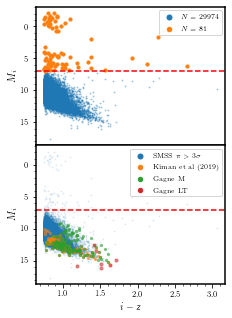

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))
plt.subplots_adjust(hspace=0.0)

axis2 = plt.subplot(2,1,1)
ax1=axis2.scatter(dwarfs['i_psf'] - dwarfs['z_psf'],dwarfs['M_i'],s=1,c='C0',label='$N = {}$'.format(len(dwarfs)))
ax2=axis2.scatter(giants['i_z'],giants['M_i'],s=10,c='C1',label='$N = {}$'.format(len(giants)))
axis2.axhline(y=7,ls='--',color='r')
#ax3=plt.scatter(gagne_m_overlap_clean['i_z'],gagne_m_overlap_clean['M_i'],s=size,c='C2',label='Gagne M')
#ax4=plt.scatter(gagne_lty_overlap_clean['i_z'],gagne_lty_overlap_clean['M_i'],s=size,c='C3',label='Gagne LT')
#plt.axhline(y=10)
axis2.set_xlabel('$i - z$')
axis2.set_ylabel('$M_i$')
leg=plt.legend(loc='best',markerscale=5)
leg.legendHandles[1]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.3)
ax2.set_alpha(1.0)
#ax3.set_alpha(1.0)
#ax4.set_alpha(1.0)
axis2.minorticks_on()

axis2.invert_yaxis()

axis1 = plt.subplot(2,1,2)
size = 1
ax1=axis1.scatter(sigma_cut['i_psf'] - sigma_cut['z_psf'],sigma_cut['M_i'],s=1,c='C0',label='SMSS $\pi > 3\sigma$',rasterized=True)
ax2=axis1.scatter(kiman_sm_overlap_clean['i_z'],kiman_sm_overlap_clean['M_i'],s=5,c='C1',label='Kiman et al (2019)')
ax3=axis1.scatter(gagne_m_overlap_clean['i_z'],gagne_m_overlap_clean['M_i'],s=5,c='C2',label='Gagne M')
ax4=axis1.scatter(gagne_lty_overlap_clean['i_z'],gagne_lty_overlap_clean['M_i'],s=10,c='C3',label='Gagne LT')
axis1.axhline(y=7,ls='--',color='r')
axis1.set_xlabel('$i - z$')
axis1.set_ylabel('$M_i$')
leg=axis1.legend(loc='upper right',markerscale=5)
leg.legendHandles[3]._sizes = [20]
leg.legendHandles[2]._sizes = [20]
leg.legendHandles[1]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(0.5)
ax3.set_alpha(0.5)
ax4.set_alpha(0.5)
axis1.invert_yaxis()

plt.minorticks_on()
#plt.savefig('gdrive/My Drive/Colab Notebooks/figures/M_i_cut_dwarfs_giants_smss.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

In [ ]:
levels_1 = conf_levels(sigma_cut['i_psf'] - sigma_cut['z_psf'],sigma_cut['M_i'],bin_n=20)
levels_2 = conf_levels(kiman_sm_overlap_clean['i_z'],kiman_sm_overlap_clean['M_i'],bin_n=5)
levels_3 = conf_levels(gagne_m_overlap_clean['i_z'],gagne_m_overlap_clean['M_i'],bin_n=5)
levels_4 = conf_levels(gagne_lty_overlap_clean['i_z'],gagne_lty_overlap_clean['M_i'],bin_n=2)
print(levels_1)
print(levels_2)
print(levels_3)
print(levels_4)

[0.08312265085579054, 0.6974692851740382]
[0.09973111184015852, 0.36568074341552714]
[0.09984030157518711, 0.29952090472556137]
[0.3146512662671369, 0.6293025325377078]


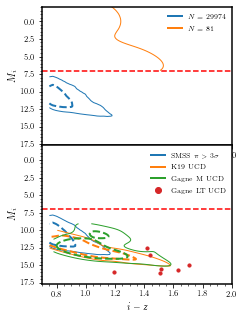

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.0)

X1,Y1,Z1 = gauss_levels(dwarfs['i_z'],dwarfs['M_i'])
X2,Y2,Z2 = gauss_levels(giants['i_z'],giants['M_i'])
levels_1 = conf_levels(dwarfs['i_z'],dwarfs['M_i'],bin_n=25)
levels_2 = conf_levels(giants['i_z'],giants['M_i'],bin_n=4)

ax1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3 = ax.axhline(y=7,ls='--',color='r')
ax.set_xlabel('$i - z$')
ax.set_ylabel('$M_i$')
ax.set_xlim(0.70,2.0)
ax.invert_yaxis()
plt.minorticks_on()

X1,Y1,Z1 = gauss_levels(sigma_cut['i_psf'] - sigma_cut['z_psf'],sigma_cut['M_i'])
X2,Y2,Z2 = gauss_levels(kiman_sm_overlap_clean['i_z'],kiman_sm_overlap_clean['M_i'])
X3,Y3,Z3 = gauss_levels(gagne_m_overlap_clean['i_z'],gagne_m_overlap_clean['M_i'])
#X4,Y4,Z4 = gauss_levels(des_pred_kiman['IMAG_DERED']-des_pred_kiman['ZMAG_DERED'],des_pred_kiman['ZMAG_DERED'] - des_pred_kiman['YMAG_DERED'])
levels_1 = conf_levels(sigma_cut['i_psf'] - sigma_cut['z_psf'],sigma_cut['M_i'],bin_n=20)
levels_2 = conf_levels(kiman_sm_overlap_clean['i_z'],kiman_sm_overlap_clean['M_i'],bin_n=5)
levels_3 = conf_levels(gagne_m_overlap_clean['i_z'],gagne_m_overlap_clean['M_i'],bin_n=5)

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax_2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax3 = ax_2.contour(X3,Y3,Z3, levels=levels_3, colors=['C2'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax4= ax_2.scatter(gagne_lty_overlap_clean['i_z'],gagne_lty_overlap_clean['M_i'],s=10,c='C3')
ax5 = ax_2.axhline(y=7,ls='--',color='r')
ax_2.set_xlabel('$i - z$')
ax_2.set_ylabel('$M_i$')

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'$N = {}$'.format(len(dwarfs)))
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'$N = {}$'.format(len(giants)))
ax.legend(loc='upper right', frameon=False)

ax_2.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'SMSS $\pi > 3\sigma$')
ax_2.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'K19 UCD')
ax_2.plot([0,0],[0,0], ls='solid', c='C2', lw=2, label=r'Gagne M UCD')
ax_2.plot([0,0],[0,0], 'o', c='C3', label=r'Gagne LT UCD')
ax_2.legend(loc='upper right', frameon=False)

plt.minorticks_on()
ax_2.set_xlim(0.70,2.0)
ax_2.invert_yaxis()
#ax_2.set_ylim(0.0,1.0)
#plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/M_i_cut_dwarfs_giants_smss_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

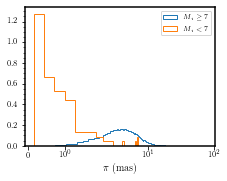

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 1*3.4*3/4.))
plt.hist(dwarfs['parallax'],bins=500,histtype='step',density=True,label='$M_i \geq 7$')
plt.hist(giants['parallax'],bins=25,histtype='step',density=True,label='$M_i < 7$')
#plt.hist(des_c4_g['log_par'],bins=1000,histtype='step',density=True)
plt.xlabel('$\pi$ (mas)') 
plt.xscale('symlog')
plt.legend(loc='upper right')
plt.minorticks_on()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_par_distributions.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

# Kiman et al. (2019) cuts
To ensure we select dwarfs for our training set, we follow the cuts made by Kiman et al 2019:

1. `parallax_over_error` > 10
2. `visibility_periods_used` > 8
3. `UWE` < 1.2 $\times$ max(1.4, $\exp(-0.2(G -  19.5))$)

`parallax_over_error` = `parallax`/`parallax_error`

In [ ]:
def uwe_squared(chi2,obs):
    return chi2/(obs - 5)
    
def uwe_cut(gmag):
    return 1.2*max(1.4,np.exp(-0.2*(float(gmag) - 19.5)))


dwarfs['UWE'] = np.sqrt(uwe_squared(dwarfs['astrometric_chi2_al'],
                                         dwarfs['astrometric_n_obs_al']))

filtered = dwarfs[['object_id','UWE','phot_g_mean_mag']]

# UWE cut:
s = [[col[0],col[1]] for index, col in filtered.T.iteritems() if col[1] < uwe_cut(col[2])]

s_df = pd.DataFrame(s,columns=['object_id','UWE'])
s_df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(28768, 2)

In [ ]:
smss_tset_dwarfs = merger(s_df,dwarfs,l_col='object_id',r_col='object_id',method='inner')
smss_tset_dwarfs.shape

(28768, 366)

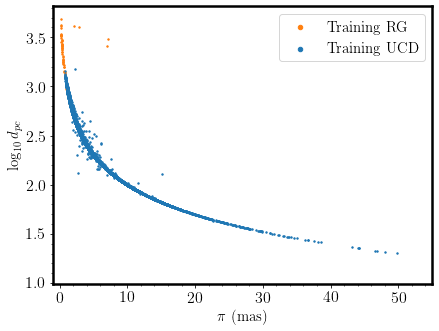

In [ ]:
plt.figure(figsize=(2*3.4,2*3.4*3/4.))
ax2=plt.scatter(giants['parallax'],np.log10(giants['rest']),
            s=2,c='C1',label='Training RG')
ax1=plt.scatter(smss_tset_dwarfs['parallax'],np.log10(smss_tset_dwarfs['rest']),
            s=2,c='C0',label='Training UCD',rasterized=True)
#plt.plot(np.arange(0,100),(10**3)/np.arange(0,100),'r',label='$f(\pi) = 10^3/\pi$')
plt.xlabel('$\pi$ (mas)')
plt.ylabel('$\log_{10}{d_{pc}}$')
leg=plt.legend(loc='best',markerscale=5,prop={'size':15})
leg.legendHandles[1]._sizes = [20]
leg.legendHandles[0]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(1.0)
ax2.set_alpha(1.0)
plt.xlim(-1.0,55)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.minorticks_on()

plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_par_v_dist.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
gagne_m_dwarfs = merger(smss_tset_dwarfs,gagne_m_overlap_clean,r_col='object_id',l_col='object_id',method='inner')
print(gagne_m_dwarfs.shape) # 366 objects

gagne_lty_dwarfs = merger(smss_tset_dwarfs,gagne_lty_overlap_clean,r_col='object_id',l_col='object_id',method='inner')
print(gagne_lty_dwarfs.shape) # 26 objects

(138, 403)
(6, 403)


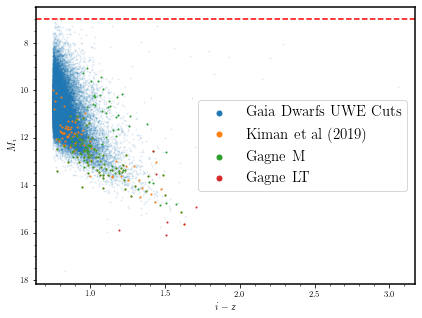

In [ ]:
fig = plt.figure(1, figsize=(2*3.4, 2*3.4*3/4.))
size = 1
ax1=plt.scatter(smss_tset_dwarfs['i_psf'] - smss_tset_dwarfs['z_psf'],smss_tset_dwarfs['M_i'],s=size,c='C0',label='Gaia Dwarfs UWE Cuts')
ax2=plt.scatter(kiman_sm_overlap_clean['i_z'],kiman_sm_overlap_clean['M_i'],s=size,c='C1',label='Kiman et al (2019)')
ax3=plt.scatter(gagne_m_dwarfs['i_z'],gagne_m_dwarfs['M_i'],s=size,c='C2',label='Gagne M')
ax4=plt.scatter(gagne_lty_overlap_clean['i_z'],gagne_lty_overlap_clean['M_i'],s=size,c='C3',label='Gagne LT')
plt.axhline(y=7,ls='--',color='r')
plt.xlabel('$i - z$')
plt.ylabel('$M_i$')
leg=plt.legend(loc='center right',markerscale=5, fontsize=15)
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax2.set_alpha(1.0)
ax3.set_alpha(1.0)
ax4.set_alpha(1.0)
plt.minorticks_on()

plt.gca().invert_yaxis()
plt.show()

In [ ]:
print('Total dwarfs and giants:',len(smss_tset_dwarfs) + len(giants))

Total dwarfs and giants: 28849


In [ ]:
giants['survey_marker'] = 'smss_gaia_parallax'
smss_tset_dwarfs['survey_marker'] = 'smss_gaia_parallax'
gagne_m_dwarfs['survey_marker'] = 'gagne_m'
gagne_lty_dwarfs['survey_marker'] = 'gagne_lty'
kiman_sm_overlap_clean['survey_marker'] = 'kiman'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
giants['label'] = 'hm*'
smss_tset_dwarfs['label'] = 'lm*'
gagne_m_dwarfs['label'] = 'lm*'
gagne_lty_dwarfs['label'] = 'lm*'
kiman_sm_overlap_clean['label'] = 'lm*'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
giants['UWE'] = np.nan
gagne_m_dwarfs['UWE'] = np.nan
gagne_lty_dwarfs['UWE'] = np.nan
kiman_sm_overlap_clean['UWE'] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sm_objs = pd.concat([smss_tset_dwarfs,giants])
sm_objs.shape

(28849, 368)

In [ ]:
known_dwarfs = pd.concat([kiman_sm_overlap_clean[smss_tset_dwarfs.columns],gagne_m_dwarfs[smss_tset_dwarfs.columns],gagne_lty_dwarfs[smss_tset_dwarfs.columns]])
print(known_dwarfs.shape)
print(Counter(known_dwarfs['survey_marker']))

known_dwarfs_nodupes = known_dwarfs.drop_duplicates(subset='object_id',keep='last')
print(Counter(known_dwarfs_nodupes['survey_marker']))
print(known_dwarfs_nodupes.shape)

(296, 368)
Counter({'kiman': 152, 'gagne_m': 138, 'gagne_lty': 6})
Counter({'gagne_m': 137, 'kiman': 67, 'gagne_lty': 6})
(210, 368)


In [ ]:
gaia_par_objs = sm_objs[(~sm_objs.object_id.isin(known_dwarfs_nodupes.object_id))]
gaia_par_objs_nodupes = gaia_par_objs.drop_duplicates(subset='object_id',keep='last')
print(gaia_par_objs.shape)
print(gaia_par_objs_nodupes.shape)

(28639, 368)
(28639, 368)


In [ ]:
Counter(gaia_par_objs_nodupes.survey_marker)

Counter({'smss_gaia_parallax': 28639})

In [ ]:
smss_tset_psources = pd.concat([gaia_par_objs_nodupes,known_dwarfs_nodupes])
smss_tset_psources_nodupes = smss_tset_psources.drop_duplicates(subset='object_id',keep='last')
smss_tset_psources.shape

(28849, 368)

In [ ]:
Counter(smss_tset_psources_nodupes.survey_marker)

Counter({'gagne_lty': 6,
         'gagne_m': 137,
         'kiman': 67,
         'smss_gaia_parallax': 28639})

In [ ]:
smss_tset_psources_nodupes.to_csv(path_sm+'smss_red_trainingset_nodupes.csv.gz',compression='gzip',index=False)

In [ ]:
smss_tset_psources_nodupes = pd.read_csv(path_sm+'smss_red_trainingset_nodupes.csv.gz',compression='gzip',low_memory=False)

In [ ]:
# parameter space plots
lm = smss_tset_psources_nodupes[smss_tset_psources_nodupes['label'] == 'lm*']
hm = smss_tset_psources_nodupes[smss_tset_psources_nodupes['label'] == 'hm*']

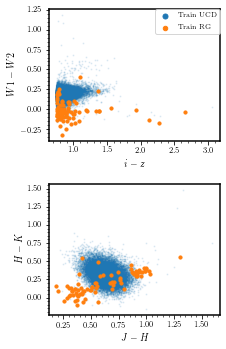

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)
ax1 = ax.scatter(lm['i_psf']-lm['z_psf'],lm['w1mpro'] - lm['w2mpro'],
                c='C0',s=1,label='Train UCD',rasterized=True)
ax4 = ax.scatter(hm['i_psf']-hm['z_psf'],hm['w1mpro'] - hm['w2mpro'],
                  c='C1',s=10,label='Train RG')
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
#plt.xlim(0,5)
#plt.ylim(-0.5,2.0)
leg=plt.legend(loc='upper right',markerscale=5, borderaxespad=0.)
leg.legendHandles[1]._sizes = [20]
for l in leg.get_lines():
    l.set_alpha(1)
ax1.set_alpha(0.1)
ax4.set_alpha(1.0)
plt.minorticks_on()


ax_2 = plt.subplot(2,1,2)
ax1=ax_2.scatter(lm['j_m'] - lm['h_m'],lm['h_m'] - lm['k_m'],
                c='C0',s=1,label='Train UCD',rasterized=True)
ax4 = ax_2.scatter(hm['j_m'] - hm['h_m'],hm['h_m'] - hm['k_m'],
                  c='C1',s=10,label='Train RG')
plt.xlabel('$J - H$')
plt.ylabel('$H - K$')
ax1.set_alpha(0.1)
ax4.set_alpha(1.0)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_training_parameter_space_scatter.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()

In [ ]:
levels_1 = conf_levels(lm['i_psf'] - lm['z_psf'],lm['w1mpro'] - lm['w2mpro'],bin_n = 15)
levels_2 = conf_levels(hm['i_psf'] - hm['z_psf'],hm['w1mpro'] - hm['w2mpro'],bin_n=4)
print(levels_1)
print(levels_2)

[0.9019398513426294, 14.61659295551052]
[0.2859881397870255, 2.573893258071785]


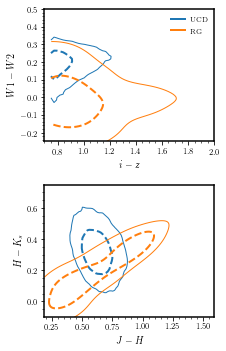

In [ ]:
fig = plt.figure(1, figsize=(1*3.4, 2*3.4*3/4.))

ax = plt.subplot(2,1,1)

X1,Y1,Z1 = gauss_levels(lm['i_psf'] - lm['z_psf'],lm['w1mpro'] - lm['w2mpro'])
X2,Y2,Z2 = gauss_levels(hm['i_psf'] - hm['z_psf'],hm['w1mpro'] - hm['w2mpro'])
levels_1 = conf_levels(lm['i_psf'] - lm['z_psf'],lm['w1mpro'] - lm['w2mpro'],bin_n = 15)
levels_2 = conf_levels(hm['i_psf'] - hm['z_psf'],hm['w1mpro'] - hm['w2mpro'],bin_n=4)

ax1 = ax.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
plt.ylabel('$W1 - W2$')
plt.xlabel('$i - z$')
ax.set_xlim(0.70,2.0)
ax.set_ylim(-0.25,0.50)
plt.minorticks_on()

X1,Y1,Z1 = gauss_levels(lm['j_m'] - lm['h_m'],lm['h_m'] - lm['k_m'])
X2,Y2,Z2 = gauss_levels(hm['j_m'] - hm['h_m'],hm['h_m'] - hm['k_m'])
levels_1 = conf_levels(lm['j_m'] - lm['h_m'],lm['h_m'] - lm['k_m'],bin_n = 15)
levels_2 = conf_levels(hm['j_m'] - hm['h_m'],hm['h_m'] - hm['k_m'],bin_n=5)

ax_2 = plt.subplot(2,1,2)
ax1 = ax_2.contour(X1,Y1,Z1, levels=levels_1, colors=['C0'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
ax2 = ax_2.contour(X2,Y2,Z2, levels=levels_2, colors=['C1'], linestyles=['solid','--','-.'], linewidths=[1,2], zorder=-20)
#ax_2.set_xlim(0.70,2.0)
ax_2.set_ylim(-0.1,0.75)
plt.xlabel('$J - H$')
plt.ylabel('$H - K_s$')

ax.plot([0,0],[0,0], ls='solid', c='C0', lw=2, label=r'UCD')
ax.plot([0,0],[0,0], ls='solid', c='C1', lw=2, label=r'RG')
ax.legend(loc='upper right', frameon=False)

plt.minorticks_on()
plt.tight_layout()
plt.savefig('gdrive/My Drive/Colab Notebooks/figures/smss_training_parameter_space_contour.pdf',dpi=300,bbox_inches='tight',padding=0)
plt.show()